# Robotics II - the Jetbot track follower

### <u>Authors:</u>
- Maria Musiał : 156062
- Joanna Szczublińska : 156070
- Wiktoria Szarzyńska : 156058

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset 
import torch
import torchvision.models as models
import PIL.Image
import string
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

### Defining dataset class

In [ ]:
# root_dir = "put_jetbot_dataset/dataset/"
# samples=[]

class JetBotDataset(Dataset):
    """
    Dataset that reads images and forward, left values from csv (from root_dir), uses transformations externally defined.
    Returns image(rgb), [forward, left] tensor
    """
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        
        folders = [name for name in os.listdir(root_dir)
           if os.path.isdir(os.path.join(root_dir, name))]

        for folder_name in folders:
            file_name = folder_name + ".csv"
            csv_path = os.path.join(root_dir, file_name)
            folder_path = os.path.join(root_dir, folder_name)
            # print(folder_name, file_name, csv_path, folder_path)

            if not os.path.exists(csv_path):
                print(f"Warning: CSV file {csv_path} not found, skipping folder {folder_name}")
                continue
            
            try:
                df = pd.read_csv(csv_path, header=None, dtype={"0":"int32", "1":"float64", "2":"float64"})
                df.columns = ["filename", "forward", "left"]

                for _, row in df.iterrows():
                    img_path = os.path.join(folder_path, str(row['filename'])[:-2].zfill(4)+".jpg")     # row[filename gives number of photo]; zfill gives leading zeros
                    if not os.path.exists(img_path):
                        print(f"Warnign: Image file {img_path} not found.")
                        continue
                    self.samples.append((img_path, float(row["forward"]), float(row["left"])))
            except Exception as e:
                print(f"Error processing {csv_path}: e")
                
        print(f"Loaded {len(self.samples)} samples from {len(folders)} folders")

                
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        img_path, forward, left = self.samples[idx]
        
        try:
            image = PIL.Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)

            if left < -0.5:
                left1, left2, left3 = 1, 0, 0
            elif left > 0.5:
                left1, left2, left3 = 0, 0, 1
            else:
                left1, left2, left3 = 0, 1, 0

            forward = torch.tensor(forward, dtype=torch.float32)
            left_classes = torch.tensor([left1, left2, left3], dtype=torch.long)

            return image, (forward, left_classes)


            # return image, torch.tensor([forward, left], dtype=torch.float32)
        

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            placeholder = torch.zeros((3,224,224))
            return placeholder, torch.tensor([0.0, 0.0], dtype=torch.float32)
    
    
def get_transforms(augument=True):
    """Create transformations for training and validation"""
    common_transforms = [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
    # augmentation
    if augument:
        # Transformations: resize to 224x224, color jitter, normalize for rgb values predefined using imagenet 
        train_transforms = [
            transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),  #color transofmrations
            transforms.RandomRotation(10),
            *common_transforms
        ]  
        return transforms.Compose(train_transforms)
    else:
        return transforms.Compose(common_transforms)

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt

def plot_samples_per_folder(dataset):
    folder_counts = defaultdict(int)
    for img_path, _, _ in dataset.samples:
        folder = os.path.basename(os.path.dirname(img_path))
        folder_counts[folder] += 1
    
    folders = list(folder_counts.keys())
    counts = [folder_counts[f] for f in folders]
    
    plt.figure(figsize=(12, 6))
    plt.bar(folders, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title("Samples per Folder")
    plt.ylabel("Number of Samples")
    plt.tight_layout()
    plt.show()


def show_sample_images(dataset, num=9):
    indices = np.random.choice(len(dataset), num, replace=False)
    plt.figure(figsize=(12, 12))
    
    for i, idx in enumerate(indices):
        img, (fwd, left) = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        img = np.clip(img, 0, 1)
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Fwd: {fwd:.2f}, Left: {left:.2f}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

def plot_target_distributions(dataset):
    forward_vals = [s[1] for s in dataset.samples]
    left_vals = [s[2] for s in dataset.samples]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.hist(forward_vals, bins=50, color='skyblue')
    plt.title("Forward Distribution")
    plt.xlabel("Forward")
    
    plt.subplot(1, 3, 2)
    plt.hist(left_vals, bins=50, color='salmon')
    plt.title("Left Distribution")
    plt.xlabel("Left")

    plt.subplot(1, 3, 3)
    plt.scatter(forward_vals, left_vals, alpha=0.3, s=5)
    plt.title("Forward vs Left")
    plt.xlabel("Forward")
    plt.ylabel("Left")

    plt.tight_layout()
    plt.show()



Warnign: Image file dataset/1652876206.2541456\0008.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0009.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0010.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0011.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0012.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0013.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0014.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0015.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0019.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0020.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0021.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0022.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0023.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0024.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0025.jpg not fo

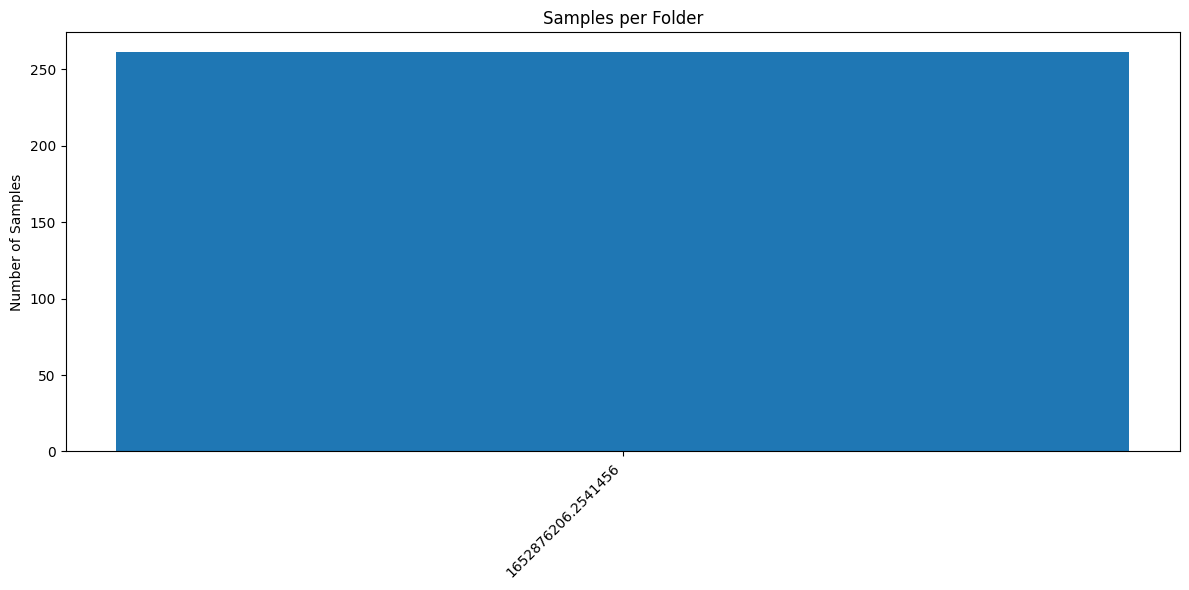

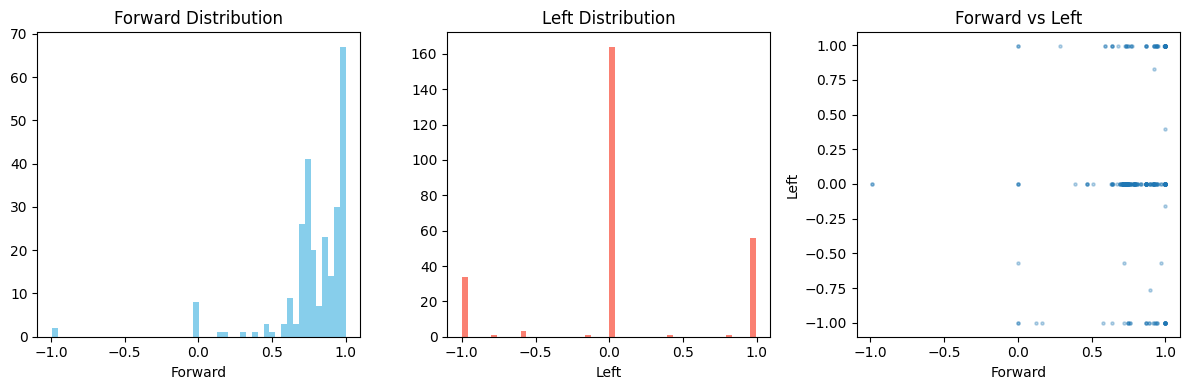

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = JetBotDataset(root_dir="dataset/", transform=transform)

plot_samples_per_folder(train_dataset)
plot_target_distributions(train_dataset)
# show_sample_images(train_dataset, num=6)


### Dividing dataset to train, test, validation

In [ ]:
from torch.utils.data import random_split, DataLoader

def create_datasets(root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=32):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"

    # Get transforms
    train_transform = get_transforms(augument=True)
    val_test_transform = get_transforms(augument=False)

    # Load full dataset with dummy transform (we'll override it in subsets)
    full_dataset = JetBotDataset(root_dir, transform=None)
    total_size = len(full_dataset)

    # Compute lengths
    train_len = int(total_size * train_ratio)
    val_len = int(total_size * val_ratio)
    test_len = total_size - train_len - val_len

    # Split dataset
    train_set, val_set, test_set = random_split(full_dataset, [train_len, val_len, test_len])

    # Assign transforms manually (they use the same dataset class)
    train_set.dataset.transform = train_transform
    val_set.dataset.transform = val_test_transform
    test_set.dataset.transform = val_test_transform

    # Optionally return DataLoaders
    return {
        "train": DataLoader(train_set, batch_size=batch_size, shuffle=True),
        "val": DataLoader(val_set, batch_size=batch_size),
        "test": DataLoader(test_set, batch_size=batch_size)
    }


## Displaying dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch

# Function to unnormalize using ImageNet stats
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img * std + mean

# Show a batch of images from DataLoader
def show_batch(data_loader):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    print(len(images))
    print(len(labels))
    # print(labels)
    # Unnormalize all images in the batch
    unnorm_images = unnormalize(images.clone())

    # Create a grid and display
    img_grid = torchvision.utils.make_grid(unnorm_images, nrow=5)
    npimg = img_grid.permute(1, 2, 0).numpy()
    npimg = np.clip(npimg, 0, 1)

    plt.figure(figsize=(15, 5))
    plt.imshow(npimg)
    plt.axis("off")

    # Show the [forward, left] labels
    print("Labels (forward, left):")
    
    for i in range(min(8, len(images))):  # show up to 5 labels
        print(f"Forward: {labels[0][i]}, Left: {labels[1][i]}")
        # print(f"{i+1}. {labels[i][0]}")

# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# print(images[0], labels[0])
# # Example usage (assuming train_loader exists)
# show_batch(train_loader)


In [ ]:
data = create_datasets(root_dir = "dataset/", batch_size=8)
train_loader = data["train"]
val_loader = data["val"]
test_loader = data["test"]


Warnign: Image file dataset/1652876206.2541456\0008.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0009.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0010.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0011.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0012.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0013.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0014.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0015.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0019.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0020.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0021.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0022.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0023.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0024.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0025.jpg not fo

8
2
Labels (forward, left):
Forward: 0.9140625, Left: tensor([0, 1, 0])
Forward: 0.953125, Left: tensor([0, 1, 0])
Forward: 0.7578125, Left: tensor([0, 1, 0])
Forward: 0.578125, Left: tensor([1, 0, 0])
Forward: 0.75, Left: tensor([0, 1, 0])
Forward: 1.0, Left: tensor([0, 0, 1])
Forward: 0.7734375, Left: tensor([0, 1, 0])
Forward: 0.75, Left: tensor([0, 1, 0])


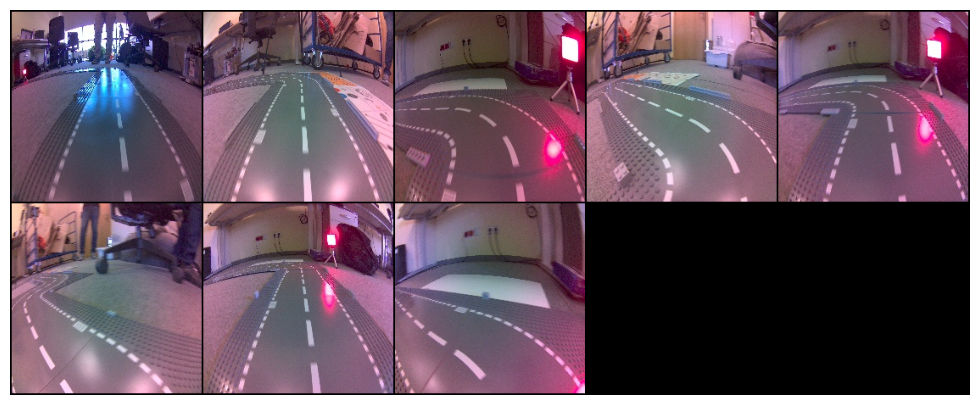

In [ ]:
show_batch(train_loader)


###  Nvidia paper CNN


In [ ]:
class NvidiaPaperNetwork(nn.Module):
    """implementation of nvidia's end-to-end self driving cars network"""
    def __init__(self):
        super(NvidiaPaperNetwork, self).__init__()
        
        
        self.conv1a = nn.Conv2d(3, 12, kernel_size=3, stride=2, padding=1)
        self.conv1b = nn.Conv2d(12, 12, kernel_size=3, stride=1, padding=1)
        
        self.conv2a = nn.Conv2d(12, 18, kernel_size=3, stride=2, padding=1)
        self.conv2b = nn.Conv2d(18, 18, kernel_size=3, stride=1, padding=1)
        
        self.conv3a = nn.Conv2d(18, 24, kernel_size=3, stride=2, padding=1)
        self.conv3b = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1)
        
        self.conv4 = nn.Conv2d(24, 32, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        
        # 224 -> 112 -> 56 -> 28 -> 14 -> 14 after all conv layers
        feature_size = 32 *14*14  #32 channels of 28x28
        self.fc1 = nn.Linear(feature_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
        # self.output = nn.Linear(10, 2)  # Output of 2 values: forward, left
        self.output = nn.Linear(10, 4)  # 1 forward (regression), 3 left logits (classification)

        
    def forward(self, x):
        
        x = F.relu(self.conv1a(x))
        x = F.relu(self.conv1b(x))
        
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2b(x))
        
        x = F.relu(self.conv3a(x))
        x = F.relu(self.conv3b(x))
        
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        
        x = x.view(x.size(0), -1)  #Flatten the output 
    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        x = self.output(x)
        
        return x
    

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = NvidiaPaperNetwork().to(device)

Using device: cpu


In [ ]:
print("\nModel architecture:")
print(model)

# Count number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")



Model architecture:
NvidiaPaperNetwork(
  (conv1a): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv1b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(12, 18, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2b): Conv2d(18, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(18, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3b): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=4, bias=True)
)

Total parameters: 435,778


In [ ]:
class MultiTaskLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.regression_loss = nn.HuberLoss()
        self.classification_loss = nn.CrossEntropyLoss()

    def forward(self, predictions, targets):
        pred_forward = predictions[:, 0]  # (B,)
        pred_lefts = predictions[:, 1:]   # (B, 3)

        target_forward, target_lefts = targets  # (B,), (B, 3)

        # Regression loss
        reg_loss = self.regression_loss(pred_forward, target_forward)

        # Classification loss (assumes targets are class indices)
        class_loss = self.classification_loss(pred_lefts, target_lefts)

        return reg_loss + class_loss  # or weighted sum


In [ ]:
def training(model, train_loader, val_loader, device, epochs=120):
    """
    Training loop with model saving
    """
    best_model_path = 'best_model_jetbot.pth'
    best_loss = 1e9
    patience = 25
    patience_counter = 0    
    
    optimizer = optim.Adam(model.parameters(), lr =0.0003, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)
    criterion = MultiTaskLoss()

    
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
        
        model.train()
        train_loss = 0.0
        
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for images, targets in train_iterator:
            images = images.to(device)
            
            forward, left_classes = targets
            forward = forward.to(device)
            left_classes = left_classes.to(device)

            optimizer.zero_grad()

            outputs = model(images)

            # Now split outputs: outputs[: , 0] for forward, outputs[:, 1:] for classification
            pred_forward = outputs[:, 0]
            pred_left = outputs[:, 1:]

            loss_reg = F.mse_loss(pred_forward, forward)
            loss_cls = F.cross_entropy(pred_left, left_classes.argmax(dim=1))  # If using one-hot labels

            loss = loss_reg + loss_cls  # or weighted sum
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_iterator.set_postfix(loss=float(loss))
            
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Test]")
            for images, targets in val_iterator:
                images = images.to(device)
                
                forward, left_classes = targets
                forward = forward.to(device)
                left_classes = left_classes.to(device)

                outputs = model(images)

                pred_forward = outputs[:, 0]
                pred_left = outputs[:, 1:]

                loss_reg = F.mse_loss(pred_forward, forward)
                loss_cls = F.cross_entropy(pred_left, left_classes.argmax(dim=1))

                loss = loss_reg + loss_cls
                val_loss += float(loss)

                val_iterator.set_postfix(loss=float(loss))

                        
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
            
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.6f} - Val loss: {val_loss:.6f}")
        
        # Save best model
        if val_loss < best_loss:
            torch.save(model.state_dict(), best_model_path)
            best_loss = val_loss
            patience_counter = 0
            print(f"New best model saved with val loss: {val_loss:.6f}")
        else:
            patience_counter += 1
            
    print(f"Training completed. Best val loss: {best_loss:.6f}")
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Val Loss')
    plt.legend()
    plt.savefig('loss_curves.png')
    plt.show()
    
    return best_model_path

In [ ]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test set and visualize predictions.
    """
    model.eval()
    all_targets_forward = []
    all_preds_forward = []

    all_targets_left = []
    all_preds_left = []

    test_loss = 0.0

    with torch.no_grad():
        test_iterator = tqdm(test_loader, desc="Evaluating")

        for images, targets in test_iterator:
            
            images = images.to(device)
            forward, left_classes = targets
            forward = forward.to(device)
            left_classes = left_classes.to(device)

            outputs = model(images)
            print(outputs)

            pred_forward = outputs[:, 0]
            pred_left_logits = outputs[:, 1:]
            pred_left_class = pred_left_logits.argmax(dim=1)
            target_left_class = left_classes.argmax(dim=1)
            

            print("1",pred_left_class)
            print("2",target_left_class)

            # Compute loss
            loss_reg = F.mse_loss(pred_forward, forward)
            loss_cls = F.cross_entropy(pred_left_logits, target_left_class)
            loss = loss_reg + loss_cls
            test_loss += float(loss)

            # Save for analysis
            all_preds_forward.extend(pred_forward.cpu().numpy())
            all_targets_forward.extend(forward.cpu().numpy())

            all_preds_left.extend(pred_left_class.cpu().numpy())
            all_targets_left.extend(target_left_class.cpu().numpy())

            test_iterator.set_postfix(loss=float(loss))

        test_loss /= len(test_loader)
        print(f"\nFinal test loss: {test_loss:.6f}")

    # Calculate metrics
    all_preds_forward = np.array(all_preds_forward)
    all_targets_forward = np.array(all_targets_forward)
    all_preds_left = np.array(all_preds_left)
    all_targets_left = np.array(all_targets_left)

    # Forward regression error
    mae_forward = np.mean(np.abs(all_preds_forward - all_targets_forward))
    print(f"Mean Absolute Error (Forward): {mae_forward:.6f}")

    # Left classification accuracy
    acc_left = np.mean(all_preds_left == all_targets_left)
    print(f"Classification Accuracy (Left): {acc_left:.4f}")

    # Visualization (only for forward)
    plt.figure(figsize=(10, 6))
    plt.plot(all_targets_forward, label='True Forward', color='blue')
    plt.plot(all_preds_forward, label='Predicted Forward', color='red', alpha=0.7)
    plt.title("Forward (Regression) Predictions vs Ground Truth")
    plt.xlabel("Sample")
    plt.ylabel("Forward Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Visualization (for left classification)
    plt.figure(figsize=(10, 6))
    plt.plot(all_targets_left, label='True Left', color='blue')
    plt.plot(all_preds_left, label='Predicted Left', color='green', alpha=0.7)
    plt.title("Left (Classification) Predictions vs Ground Truth")
    plt.xlabel("Sample")
    plt.ylabel("Left Class (-1, 0, 1)")
    plt.legend()
    plt.grid(True)
    plt.show()



    return test_loss, mae_forward, acc_left


Using device: cpu
Warnign: Image file dataset/1652876206.2541456\0008.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0009.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0010.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0011.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0012.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0013.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0014.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0015.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0019.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0020.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0021.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0022.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0023.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0024.jpg not found.
Warnign: Image file dataset/1652876206.25414

Epoch 1/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 21.96it/s, loss=1.92]


Epoch 1/120 - Train loss: 0.000000 - Val loss: 1.939619
New best model saved with val loss: 1.939619


Epoch 2/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.06it/s, loss=1.84]


Epoch 2/120 - Train loss: 0.000000 - Val loss: 1.851176
New best model saved with val loss: 1.851176


Epoch 3/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.23it/s, loss=1.34]


Epoch 3/120 - Train loss: 0.000000 - Val loss: 1.345162
New best model saved with val loss: 1.345162


Epoch 4/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 20.28it/s, loss=1.3]


Epoch 4/120 - Train loss: 0.000000 - Val loss: 1.307573
New best model saved with val loss: 1.307573


Epoch 5/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.54it/s, loss=1.24]


Epoch 5/120 - Train loss: 0.000000 - Val loss: 1.244087
New best model saved with val loss: 1.244087


Epoch 6/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.17it/s, loss=1.21]


Epoch 6/120 - Train loss: 0.000000 - Val loss: 1.222634
New best model saved with val loss: 1.222634


Epoch 7/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.11it/s, loss=1.19]


Epoch 7/120 - Train loss: 0.000000 - Val loss: 1.194540
New best model saved with val loss: 1.194540


Epoch 8/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.26it/s, loss=1.18]


Epoch 8/120 - Train loss: 0.000000 - Val loss: 1.187544
New best model saved with val loss: 1.187544


Epoch 9/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.35it/s, loss=1.16]


Epoch 9/120 - Train loss: 0.000000 - Val loss: 1.168880
New best model saved with val loss: 1.168880


Epoch 10/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.83it/s, loss=1.16]


Epoch 10/120 - Train loss: 0.000000 - Val loss: 1.169170


Epoch 11/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.67it/s, loss=1.15]


Epoch 11/120 - Train loss: 0.000000 - Val loss: 1.155600
New best model saved with val loss: 1.155600


Epoch 12/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 15.40it/s, loss=1.15]


Epoch 12/120 - Train loss: 0.000000 - Val loss: 1.146628
New best model saved with val loss: 1.146628


Epoch 13/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.04it/s, loss=1.15]


Epoch 13/120 - Train loss: 0.000000 - Val loss: 1.153305


Epoch 14/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.18it/s, loss=1.13]


Epoch 14/120 - Train loss: 0.000000 - Val loss: 1.128035
New best model saved with val loss: 1.128035


Epoch 15/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.62it/s, loss=1.13]


Epoch 15/120 - Train loss: 0.000000 - Val loss: 1.128395


Epoch 16/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.28it/s, loss=1.12]


Epoch 16/120 - Train loss: 0.000000 - Val loss: 1.126024
New best model saved with val loss: 1.126024


Epoch 17/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.15it/s, loss=1.11]


Epoch 17/120 - Train loss: 0.000000 - Val loss: 1.108658
New best model saved with val loss: 1.108658


Epoch 18/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 14.64it/s, loss=1.13]


Epoch 18/120 - Train loss: 0.000000 - Val loss: 1.117269


Epoch 19/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.52it/s, loss=1.1]


Epoch 19/120 - Train loss: 0.000000 - Val loss: 1.105935
New best model saved with val loss: 1.105935


Epoch 20/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.23it/s, loss=1.1]


Epoch 20/120 - Train loss: 0.000000 - Val loss: 1.091064
New best model saved with val loss: 1.091064


Epoch 21/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.31it/s, loss=1.06]


Epoch 21/120 - Train loss: 0.000000 - Val loss: 1.065013
New best model saved with val loss: 1.065013


Epoch 22/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.49it/s, loss=1.04]


Epoch 22/120 - Train loss: 0.000000 - Val loss: 1.033238
New best model saved with val loss: 1.033238


Epoch 23/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.94it/s, loss=1.09]


Epoch 23/120 - Train loss: 0.000000 - Val loss: 1.072759


Epoch 24/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.00it/s, loss=1.02]


Epoch 24/120 - Train loss: 0.000000 - Val loss: 1.010602
New best model saved with val loss: 1.010602


Epoch 25/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.48it/s, loss=1.04]


Epoch 25/120 - Train loss: 0.000000 - Val loss: 1.025320


Epoch 26/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.21it/s, loss=1.18]


Epoch 26/120 - Train loss: 0.000000 - Val loss: 1.183350


Epoch 27/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.82it/s, loss=1.08]


Epoch 27/120 - Train loss: 0.000000 - Val loss: 1.054359


Epoch 28/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.75it/s, loss=1.08]


Epoch 28/120 - Train loss: 0.000000 - Val loss: 1.061005


Epoch 29/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.18it/s, loss=1.03]


Epoch 29/120 - Train loss: 0.000000 - Val loss: 1.013391


Epoch 30/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.90it/s, loss=1.06]


Epoch 30/120 - Train loss: 0.000000 - Val loss: 1.038443


Epoch 31/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.97it/s, loss=1.02]


Epoch 31/120 - Train loss: 0.000000 - Val loss: 1.020683


Epoch 32/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.75it/s, loss=1.07]


Epoch 32/120 - Train loss: 0.000000 - Val loss: 1.076173


Epoch 33/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 14.84it/s, loss=1.01]


Epoch 33/120 - Train loss: 0.000000 - Val loss: 1.034053


Epoch 34/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.87it/s, loss=1.01]


Epoch 34/120 - Train loss: 0.000000 - Val loss: 1.042047


Epoch 35/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.67it/s, loss=1.01]


Epoch 35/120 - Train loss: 0.000000 - Val loss: 1.031601


Epoch 36/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 19.09it/s, loss=0.993]


Epoch 36/120 - Train loss: 0.000000 - Val loss: 1.029983


Epoch 37/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.27it/s, loss=1]


Epoch 37/120 - Train loss: 0.000000 - Val loss: 1.024720


Epoch 38/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.95it/s, loss=1.03]


Epoch 38/120 - Train loss: 0.000000 - Val loss: 1.058780


Epoch 39/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 18.00it/s, loss=1.02]


Epoch 39/120 - Train loss: 0.000000 - Val loss: 1.036879


Epoch 40/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.56it/s, loss=0.949]


Epoch 40/120 - Train loss: 0.000000 - Val loss: 0.981349
New best model saved with val loss: 0.981349


Epoch 41/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 14.90it/s, loss=0.986]


Epoch 41/120 - Train loss: 0.000000 - Val loss: 1.016145


Epoch 42/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.15it/s, loss=1.01]


Epoch 42/120 - Train loss: 0.000000 - Val loss: 1.016951


Epoch 43/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.58it/s, loss=0.971]


Epoch 43/120 - Train loss: 0.000000 - Val loss: 1.006719


Epoch 44/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.60it/s, loss=0.988]


Epoch 44/120 - Train loss: 0.000000 - Val loss: 1.024987


Epoch 45/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.34it/s, loss=1]


Epoch 45/120 - Train loss: 0.000000 - Val loss: 1.030672


Epoch 46/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.27it/s, loss=0.997]


Epoch 46/120 - Train loss: 0.000000 - Val loss: 1.019502


Epoch 47/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.29it/s, loss=1.07]


Epoch 47/120 - Train loss: 0.000000 - Val loss: 1.070021


Epoch 48/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.05it/s, loss=1.04]


Epoch 48/120 - Train loss: 0.000000 - Val loss: 1.060176


Epoch 49/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.23it/s, loss=0.995]


Epoch 49/120 - Train loss: 0.000000 - Val loss: 1.024056


Epoch 50/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.79it/s, loss=1.03]


Epoch 50/120 - Train loss: 0.000000 - Val loss: 1.026666


Epoch 51/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.74it/s, loss=1.12]


Epoch 51/120 - Train loss: 0.000000 - Val loss: 1.071264


Epoch 52/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.58it/s, loss=1.08]


Epoch 52/120 - Train loss: 0.000000 - Val loss: 1.033689


Epoch 53/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.63it/s, loss=1.07]


Epoch 53/120 - Train loss: 0.000000 - Val loss: 1.098698


Epoch 54/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.89it/s, loss=1.07]


Epoch 54/120 - Train loss: 0.000000 - Val loss: 1.060342


Epoch 55/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.41it/s, loss=1.11]


Epoch 55/120 - Train loss: 0.000000 - Val loss: 1.087910


Epoch 56/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.83it/s, loss=1.15]


Epoch 56/120 - Train loss: 0.000000 - Val loss: 1.131427


Epoch 57/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.53it/s, loss=1.17]


Epoch 57/120 - Train loss: 0.000000 - Val loss: 1.133565


Epoch 58/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.13it/s, loss=1.14]


Epoch 58/120 - Train loss: 0.000000 - Val loss: 1.094313


Epoch 59/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.65it/s, loss=1.14]


Epoch 59/120 - Train loss: 0.000000 - Val loss: 1.095600


Epoch 60/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.02it/s, loss=1.25]


Epoch 60/120 - Train loss: 0.000000 - Val loss: 1.212272


Epoch 61/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.59it/s, loss=1.25]


Epoch 61/120 - Train loss: 0.000000 - Val loss: 1.214917


Epoch 62/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.69it/s, loss=1.25]


Epoch 62/120 - Train loss: 0.000000 - Val loss: 1.207416


Epoch 63/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.99it/s, loss=1.27]


Epoch 63/120 - Train loss: 0.000000 - Val loss: 1.240293


Epoch 64/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 17.47it/s, loss=1.21]


Epoch 64/120 - Train loss: 0.000000 - Val loss: 1.188482


Epoch 65/120 [Test]: 100%|██████████| 2/2 [00:00<00:00, 16.94it/s, loss=1.27]


Epoch 65/120 - Train loss: 0.000000 - Val loss: 1.285146
Early stopping triggered at epoch 66.
Training completed. Best val loss: 0.981349


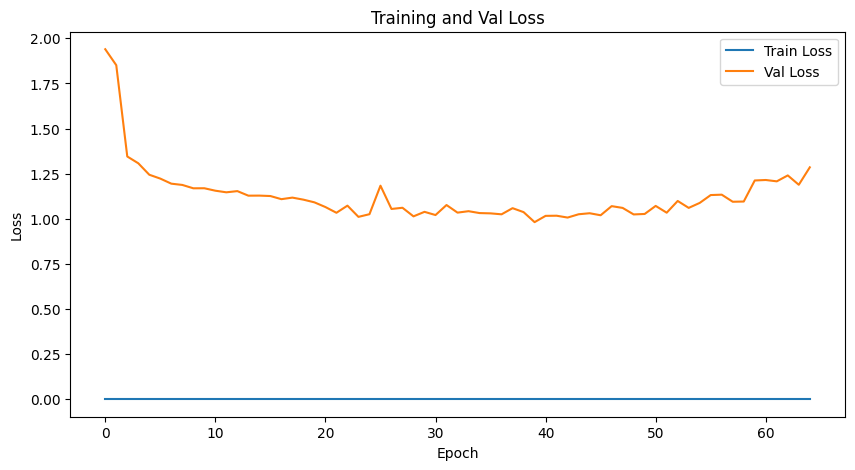

<All keys matched successfully>

In [ ]:
# root_dir = "put_jetbot_dataset/dataset/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data = create_datasets(root_dir = "dataset/", batch_size=20)
train_loader = data["train"]
val_loader = data["val"]
test_loader = data["test"]

# Create model and move to device
model = NvidiaPaperNetwork().to(device)

# Print model summary
print(model)

# Count number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Train the model
best_model_path = training(model, train_loader, test_loader, device, epochs=120)

# Load the best model
model.load_state_dict(torch.load(best_model_path))


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 14.50it/s, loss=0.949]


tensor([[ 0.4177, -0.7822, -0.0751, -1.7605],
        [ 0.6571, -0.6552,  0.3932,  0.6903],
        [ 0.6589, -2.0516,  1.0122, -0.9057],
        [ 1.0386, -1.3302,  0.7295,  0.5869],
        [ 1.0347, -0.6628,  0.2882,  1.0302],
        [ 0.8222, -2.2754,  0.6634, -2.6573],
        [ 0.9362, -0.7252,  0.3312,  0.4747],
        [ 0.7570, -2.5288,  0.7771, -2.8904],
        [ 0.6060, -2.0251,  0.9565, -1.1382],
        [ 0.6256, -2.0345,  0.9836, -1.0154],
        [ 1.0938, -2.2293,  1.1129,  0.1645],
        [ 0.5352, -1.4166,  0.7599, -0.2806],
        [ 0.6530, -0.7558,  0.4389,  0.5687],
        [ 0.6856, -2.0664,  1.0367, -0.7825],
        [ 1.2446, -0.2864, -0.1817,  0.0924],
        [ 0.4672, -0.0753, -0.3483, -1.4661],
        [ 0.9562, -1.4386, -0.4617, -4.0254],
        [ 0.7092, -1.5430,  0.4469, -1.7362],
        [ 0.6693, -2.2012,  0.7228, -2.3758],
        [ 0.4264, -0.8109, -0.0405, -1.7278]])
1 tensor([1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1])
2 tensor

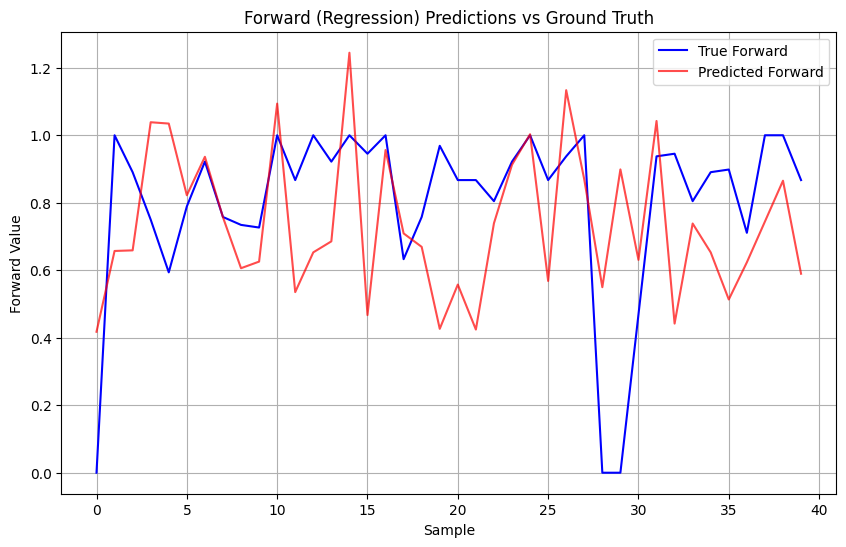

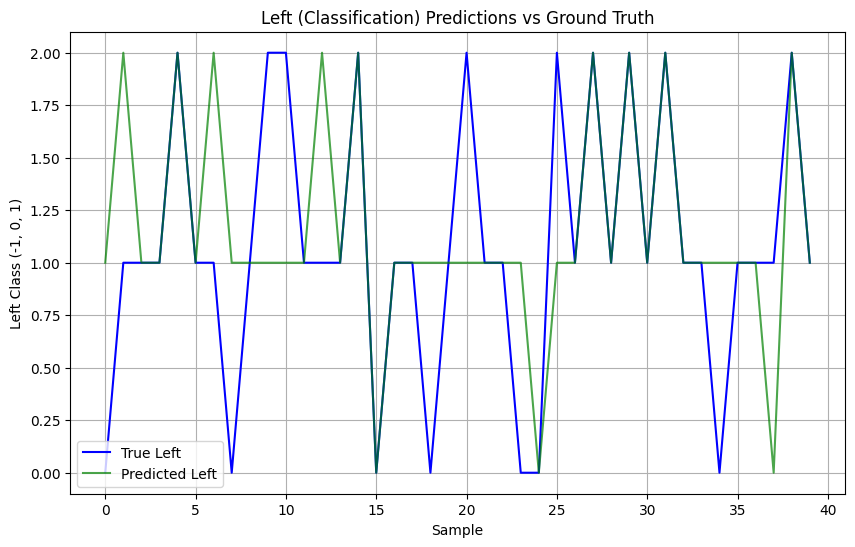

(0.9813486635684967, np.float32(0.24004583), np.float64(0.675))

In [ ]:
# Evaluate the model
evaluate_model(model, test_loader, device)

## Exporting the model

In [ ]:
model.eval()

import torch

# Assuming your model takes a (3, 224, 224) image as input
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Batch size of 1

import torch.onnx

# Path where the ONNX model will be saved
onnx_model_path = "model_jetbot2.onnx"

# Exporting the model
torch.onnx.export(
    model,               # Model to export
    dummy_input,         # Example input tensor
    onnx_model_path,     # Path to save the ONNX file
    opset_version=11,    # Define the ONNX opset version
    input_names=["input"],       # Name of the input node
    output_names=["output"],     # Name of the output node
    dynamic_axes={
        "input": {0: "batch_size"},  # Dynamic batch size
        "output": {0: "batch_size"}  # Dynamic batch size
    },
    do_constant_folding=True,  # Enable constant folding optimization
    verbose=True              # Show detailed export info
)

import onnx

# Load the exported model
onnx_model = onnx.load(onnx_model_path)

# Check if the model is valid
onnx.checker.check_model(onnx_model)

print("Model has been successfully exported to ONNX format!")



Model has been successfully exported to ONNX format!
